In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import tensor as T

In [2]:
import os
os.environ["PYTHONOPTIMIZE"] = "1"

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import berp.generators.thresholded_recognition_simple as gen
import berp.models.reindexing_regression as rr

In [5]:
params = rr.ModelParameters(lambda_=T(1.),
                            confusion=gen.phoneme_confusion,
                            threshold=T(0.7),
                            a=T(0.4),
                            b=T(0.1),
                            coef=T([0., -1.]))

In [6]:
ds = gen.sample_dataset(params)

In [7]:
ds.phoneme_onsets

tensor([[0.0000, 0.0601, 0.1434, 0.2336, 0.2924],
        [0.0000, 0.0432, 0.1337, 0.1763, 0.2662],
        [0.0000, 0.0752, 0.1215, 0.1633, 0.2302],
        [0.0000, 0.0684, 0.1277, 0.1998, 0.2471],
        [0.0000, 0.0789, 0.1653, 0.2232, 0.2682],
        [0.0000, 0.0833, 0.1767, 0.2480, 0.3305],
        [0.0000, 0.0469, 0.0927, 0.1384, 0.2224],
        [0.0000, 0.0863, 0.1664, 0.2606, 0.3133],
        [0.0000, 0.0678, 0.1206, 0.1974, 0.2772],
        [0.0000, 0.0694, 0.1416, 0.2406, 0.3060],
        [0.0000, 0.0966, 0.1840, 0.2793, 0.3527],
        [0.0000, 0.0889, 0.1845, 0.2583, 0.3526],
        [0.0000, 0.0862, 0.1474, 0.2204, 0.2661],
        [0.0000, 0.0975, 0.1419, 0.2050, 0.2992],
        [0.0000, 0.0518, 0.1444, 0.1923, 0.2901],
        [0.0000, 0.0524, 0.1064, 0.1659, 0.2270],
        [0.0000, 0.0437, 0.1234, 0.1881, 0.2699],
        [0.0000, 0.0525, 0.1469, 0.2186, 0.3165],
        [0.0000, 0.0981, 0.1788, 0.2261, 0.2993],
        [0.0000, 0.0896, 0.1666, 0.2594, 0.3203],


In [8]:
rr.predictive_model(ds.p_word, ds.candidate_phonemes, confusion=ds.params.confusion, lambda_=ds.params.lambda_)

tensor([[6.3706e-01, 9.6621e-01, 9.9804e-01, 9.9995e-01, 1.0000e+00],
        [5.3098e-02, 4.5080e-01, 6.6727e-01, 9.7611e-01, 9.9990e-01],
        [5.8461e-02, 4.9263e-01, 9.8876e-01, 9.9789e-01, 9.9993e-01],
        [1.2009e-01, 6.5261e-01, 9.7465e-01, 9.9803e-01, 9.9997e-01],
        [5.4509e-02, 4.8856e-01, 9.5717e-01, 9.9792e-01, 9.9925e-01],
        [2.0457e-02, 2.5381e-01, 9.2371e-01, 9.9429e-01, 9.9958e-01],
        [2.4570e-01, 9.0166e-01, 9.9282e-01, 9.9948e-01, 9.9998e-01],
        [6.0864e-01, 9.7453e-01, 9.9489e-01, 9.9982e-01, 9.9999e-01],
        [6.5824e-01, 9.7542e-01, 9.9931e-01, 9.9998e-01, 9.9999e-01],
        [3.0538e-01, 8.6726e-01, 9.9101e-01, 9.9974e-01, 9.9998e-01],
        [3.4329e-01, 7.3408e-01, 9.7655e-01, 9.9840e-01, 9.9996e-01],
        [1.4602e-01, 6.8841e-01, 7.4036e-01, 9.8570e-01, 9.9876e-01],
        [6.5311e-01, 9.6139e-01, 9.9793e-01, 9.9997e-01, 1.0000e+00],
        [5.5517e-01, 9.3485e-01, 9.6994e-01, 9.9800e-01, 9.9987e-01],
        [7.2328e-01,

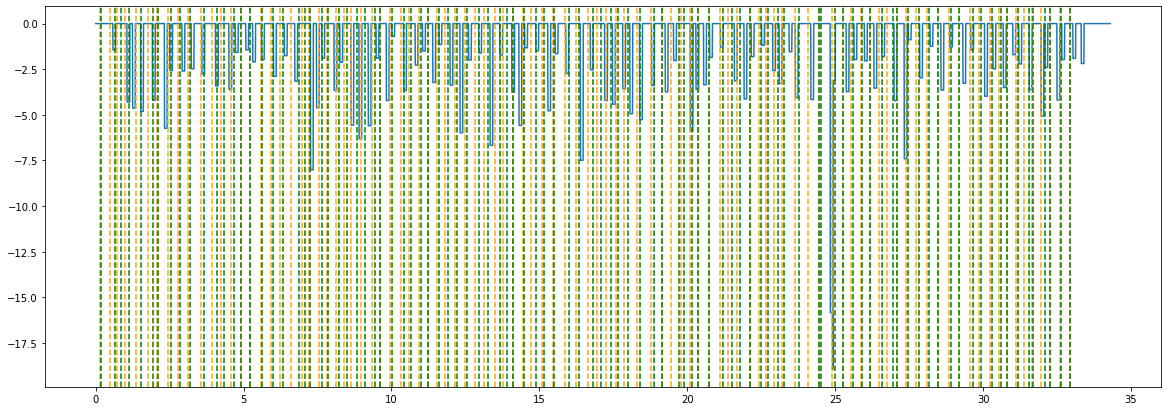

In [9]:
fig, ax = plt.subplots(figsize=(20, 7))
ax.plot(np.arange(ds.Y.shape[0]) / ds.sample_rate, ds.Y[:, 0])

for word_onset in ds.word_onsets + ds.phoneme_onsets[:, 0]:
    ax.axvline(word_onset, c="orange", linestyle="--")
for rec_onset in ds.word_onsets + ds.recognition_onsets:
    ax.axvline(rec_onset, c="green", linestyle="--")

In [10]:
offsets = ((ds.recognition_onsets + ds.params.a - ds.epoch_window[0]).numpy() * ds.sample_rate).astype(int)
ds.Y_epoch[np.arange(len(ds.Y_epoch)), offsets + 3]

tensor([[ -1.4419],
        [ -4.2978],
        [ -4.6285],
        [ -4.8107],
        [ -4.1999],
        [ -5.7368],
        [ -2.5631],
        [ -2.6011],
        [ -2.4802],
        [ -2.7536],
        [ -3.4072],
        [ -3.6095],
        [ -1.5789],
        [ -1.4410],
        [ -2.0976],
        [ -1.9756],
        [ -2.8903],
        [ -1.7580],
        [ -3.1617],
        [ -8.0161],
        [ -4.6040],
        [ -1.9007],
        [ -3.6646],
        [ -2.1226],
        [ -5.5647],
        [ -6.3104],
        [ -5.5919],
        [ -1.8923],
        [ -4.2122],
        [ -0.7002],
        [ -3.6698],
        [ -2.2740],
        [ -1.5001],
        [ -3.2273],
        [ -1.1448],
        [ -3.3738],
        [ -5.9783],
        [ -1.9970],
        [ -1.6081],
        [ -6.6725],
        [ -1.7193],
        [ -3.7625],
        [ -5.5805],
        [ -1.3242],
        [ -1.4907],
        [ -4.7765],
        [ -1.6462],
        [ -2.7307],
        [ -7.4918],
        [ -2.5357],


In [11]:
ds.p_word[:, 0]

tensor([ -1.4419,  -4.2978,  -4.6285,  -4.8107,  -4.1999,  -5.7368,  -2.5631,
         -2.6011,  -2.4802,  -2.7536,  -3.4072,  -3.6095,  -1.5789,  -1.4410,
         -2.0976,  -1.9756,  -2.8903,  -1.7580,  -3.1617,  -8.0161,  -4.6040,
         -1.9007,  -3.6646,  -2.1226,  -5.5647,  -6.3104,  -5.5919,  -1.8923,
         -4.2122,  -0.7002,  -3.6698,  -2.2740,  -1.5001,  -3.2273,  -1.1448,
         -3.3738,  -5.9783,  -1.9970,  -1.6081,  -6.6725,  -1.7193,  -3.7625,
         -5.5805,  -1.3242,  -1.4907,  -4.7765,  -1.6462,  -2.7307,  -7.4918,
         -2.5357,  -4.2144,  -4.4202,  -3.5704,  -4.9398,  -5.2646,  -3.3931,
         -3.7391,  -2.0254,  -5.8825,  -3.6060,  -3.3467,  -1.8531,  -1.2871,
         -3.1384,  -4.1337,  -1.8141,  -1.1909,  -2.5761,  -3.2827,  -1.5432,
         -4.0598,  -4.1630, -15.8414,  -3.1111,  -3.7286,  -1.9724,  -2.0461,
         -3.5369,  -1.8101,  -4.2158,  -7.4046,  -0.8842,  -2.9701,  -1.2463,
         -3.6481,  -1.2812,  -3.2702,  -1.4475,  -3.9809,  -2.47

In [12]:
ds.X_epoch

tensor([[ 1.0000,  1.4419],
        [ 1.0000,  4.2978],
        [ 1.0000,  4.6285],
        [ 1.0000,  4.8107],
        [ 1.0000,  4.1999],
        [ 1.0000,  5.7368],
        [ 1.0000,  2.5631],
        [ 1.0000,  2.6011],
        [ 1.0000,  2.4802],
        [ 1.0000,  2.7536],
        [ 1.0000,  3.4072],
        [ 1.0000,  3.6095],
        [ 1.0000,  1.5789],
        [ 1.0000,  1.4410],
        [ 1.0000,  2.0976],
        [ 1.0000,  1.9756],
        [ 1.0000,  2.8903],
        [ 1.0000,  1.7580],
        [ 1.0000,  3.1617],
        [ 1.0000,  8.0161],
        [ 1.0000,  4.6040],
        [ 1.0000,  1.9007],
        [ 1.0000,  3.6646],
        [ 1.0000,  2.1226],
        [ 1.0000,  5.5647],
        [ 1.0000,  6.3104],
        [ 1.0000,  5.5919],
        [ 1.0000,  1.8923],
        [ 1.0000,  4.2122],
        [ 1.0000,  0.7002],
        [ 1.0000,  3.6698],
        [ 1.0000,  2.2740],
        [ 1.0000,  1.5001],
        [ 1.0000,  3.2273],
        [ 1.0000,  1.1448],
        [ 1.0000,  3